In [31]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9525925068737838248
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6940786688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4573829464677031517
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
print(tf.__version__)

2.8.0


In [36]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
train_path="fer_ckplus_kdef_split/train"
test_path="fer_ckplus_kdef_split/test"
val_path="fer_ckplus_kdef_split/val"


In [38]:
(height, width, channels) = (80, 48, 3)

x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_test.append(img_arr)
        
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(height, width))

        x_val.append(img_arr)



In [39]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0





In [41]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [42]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (height, width),
                                                 batch_size = 32,
                                                 class_mode = 'sparse',
                                                 color_mode="grayscale"
                                                )
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (height, width),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                            color_mode="grayscale")
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (height, width),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                            color_mode="grayscale")

Found 26177 images belonging to 7 classes.
Found 3278 images belonging to 7 classes.
Found 3269 images belonging to 7 classes.


In [43]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [44]:
#training_set.class_indices
train_y.shape,test_y.shape,val_y.shape


((26177,), (3278,), (3269,))

In [45]:
IMAGE_SIZE = [48,80]

In [46]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [47]:
for layer in vgg.layers:
    layer.trainable = False

In [48]:
x = Flatten()(vgg.output)


In [49]:
prediction = Dense(7, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs= prediction)

In [50]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 20, 128)       0   

In [51]:
model.compile(
  tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)

In [53]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=50,
  callbacks=[early_stop],
  batch_size=64,shuffle=True)

Epoch 1/50
410/410 [==============================] - 16s 37ms/step - loss: 1.6396 - accuracy: 0.3647 - val_loss: 1.5632 - val_accuracy: 0.4078
Epoch 2/50
410/410 [==============================] - 15s 35ms/step - loss: 1.5307 - accuracy: 0.4161 - val_loss: 1.5232 - val_accuracy: 0.4221
Epoch 3/50
410/410 [==============================] - 14s 35ms/step - loss: 1.4980 - accuracy: 0.4332 - val_loss: 1.5045 - val_accuracy: 0.4329
Epoch 4/50
410/410 [==============================] - 15s 36ms/step - loss: 1.4746 - accuracy: 0.4416 - val_loss: 1.4862 - val_accuracy: 0.4362
Epoch 5/50
410/410 [==============================] - 15s 36ms/step - loss: 1.4572 - accuracy: 0.4514 - val_loss: 1.4713 - val_accuracy: 0.4420
Epoch 6/50
410/410 [==============================] - 15s 36ms/step - loss: 1.4449 - accuracy: 0.4551 - val_loss: 1.4666 - val_accuracy: 0.4405
Epoch 7/50
410/410 [==============================] - 15s 36ms/step - loss: 1.4341 - accuracy: 0.4585 - val_loss: 1.4712 - val_accuracy:

In [54]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [56]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [57]:
print(classification_report(y_pred,test_y,zero_division=0))


              precision    recall  f1-score   support

           0       0.18      0.41      0.25       207
           1       0.21      0.61      0.31        28
           2       0.30      0.30      0.30       341
           3       0.77      0.47      0.59      1470
           4       0.31      0.40      0.35       394
           5       0.25      0.34      0.29       395
           6       0.58      0.56      0.57       443

    accuracy                           0.44      3278
   macro avg       0.37      0.44      0.38      3278
weighted avg       0.54      0.44      0.47      3278



In [58]:
confusion_matrix_=confusion_matrix(y_pred,test_y)


In [59]:
confusion_matrix_

array([[ 84,   6,  19,  27,  38,  25,   8],
       [  1,  17,   0,   2,   1,   7,   0],
       [ 51,   6, 103,  29,  38,  59,  55],
       [170,  28,  78, 697, 191, 228,  78],
       [ 49,   9,  38,  53, 159,  62,  24],
       [ 88,  11,  37,  61,  50, 135,  13],
       [ 30,   3,  71,  37,  31,  25, 246]], dtype=int64)

In [60]:
import seaborn as sb
from matplotlib.colors import LogNorm, PowerNorm


Confusion Matrix


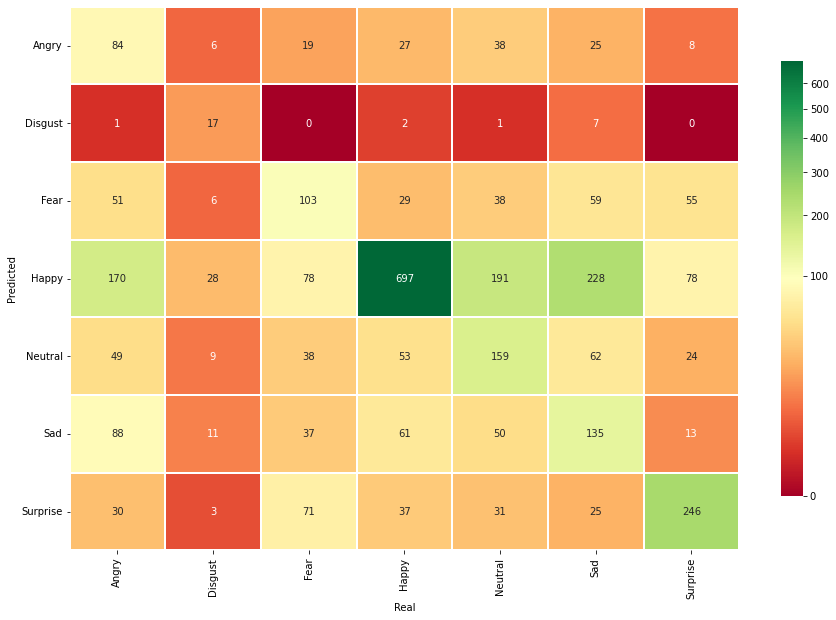

In [61]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad','Surprise']
positions = list(range(len(labels)))
positions = [x+0.5 for x in positions]

print(f'Confusion Matrix')
fig, ax = plt.subplots(figsize=(15, 10))
# plot heatmap
sb.heatmap(confusion_matrix_,
           cmap='RdYlGn',
           annot=True,
           fmt="1d",
           linewidth=0.3,
           cbar_kws={"shrink": .8},
           norm=PowerNorm(vmin=confusion_matrix_.min().min(),
                          vmax=confusion_matrix_.max().max(),
                          gamma=0.35)
          )

plt.xlabel('Real')
ax.set_xticks(positions, labels, rotation = 90)
plt.ylabel('Predicted')
ax.set_yticks(positions, labels, rotation = 0)
plt.show()